In [ ]:

import pandas as pd

movies = pd.read_csv('/content/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/tmdb_5000_credits.csv')
print("Movies:", movies.shape)
print("Credits:", credits.shape)


Movies: (4803, 20)
Credits: (4803, 4)


In [ ]:
import ast

credits = credits.rename(columns={'movie_id':'id'})
df = movies.merge(credits, on='id', how='inner')

df = df.drop_duplicates('id')
print(df.columns.tolist())
df = df.rename(columns={'title_x': 'title'})


df = df.drop(columns=['original_title'])

df['title'] = df['title'].str.lower().str.strip()

print(df[['title']].head())

def extract_list(x, key, n=3):
    items = ast.literal_eval(x)
    return ' '.join([i[key] for i in items][:n])

df['cast'] = df['cast'].apply(lambda x: extract_list(x, 'name', 3))

df['genres']   = df['genres'].apply(lambda x: extract_list(x, 'name', None))
df['keywords'] = df['keywords'].apply(lambda x: extract_list(x, 'name', None))

def get_director(x):
    crew = ast.literal_eval(x)
    for p in crew:
        if p['job']=='Director':
            return p['name']
    return 'unknown'
df['director'] = df['crew'].apply(get_director)

df = df.dropna(subset=['overview'])


['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average', 'vote_count', 'title_y', 'cast', 'crew']
                                      title
0                                    avatar
1  pirates of the caribbean: at world's end
2                                   spectre
3                     the dark knight rises
4                               john carter


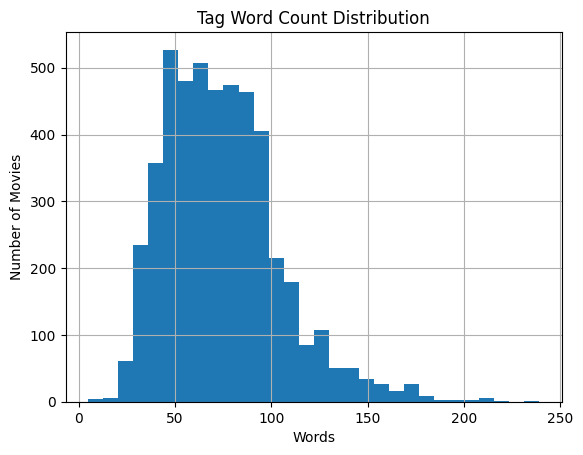

In [ ]:
import matplotlib.pyplot as plt

df['tags'].apply(lambda x: len(x.split())).hist(bins=30)
plt.title('Tag Word Count Distribution')
plt.xlabel('Words'); plt.ylabel('Number of Movies')
plt.show()


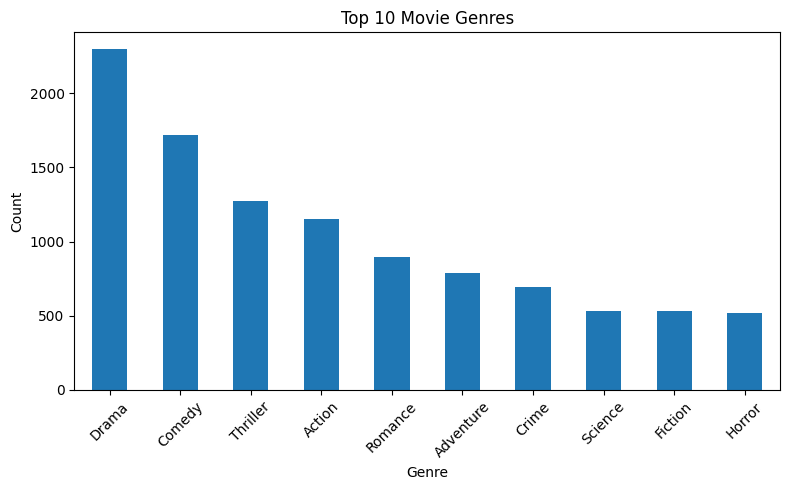

In [ ]:
genre_series = df['genres'].str.split().explode()
genre_counts = genre_series.value_counts().head(10)

plt.figure(figsize=(8,5))
genre_counts.plot(kind='bar')
plt.title('Top 10 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


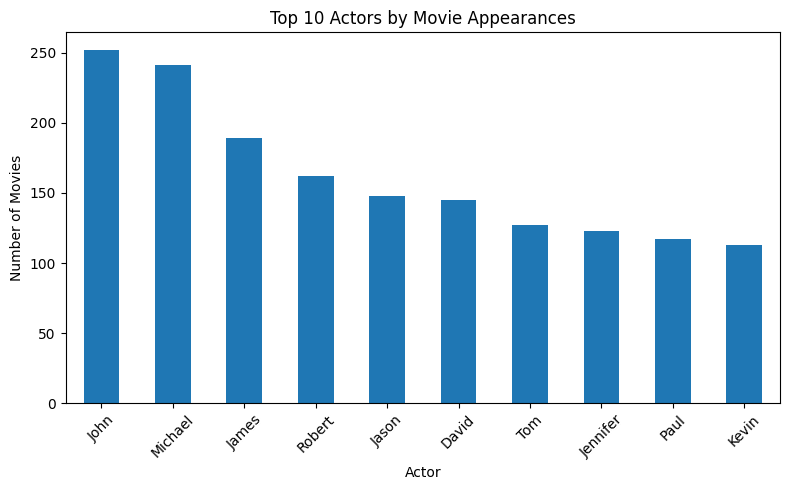

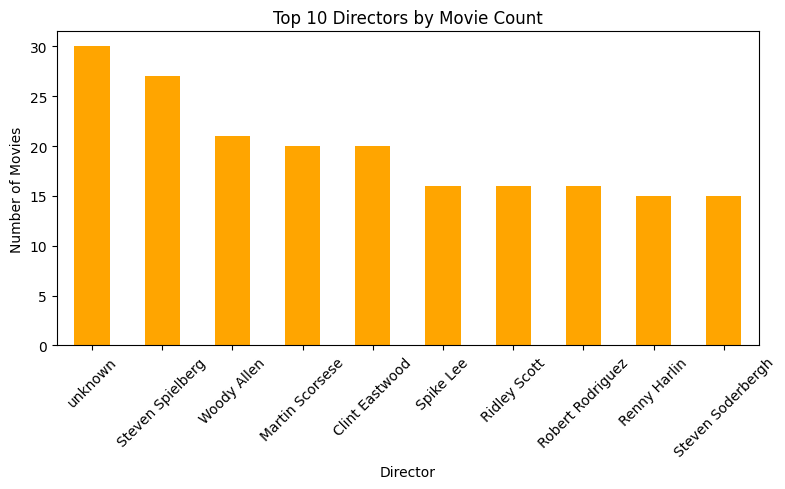

In [ ]:
actor_series = df['cast'].str.split().explode()
actor_counts = actor_series.value_counts().head(10)

plt.figure(figsize=(8,5))
actor_counts.plot(kind='bar')
plt.title('Top 10 Actors by Movie Appearances')
plt.xlabel('Actor')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

director_counts = df['director'].value_counts().head(10)

plt.figure(figsize=(8,5))
director_counts.plot(kind='bar', color='orange')
plt.title('Top 10 Directors by Movie Count')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


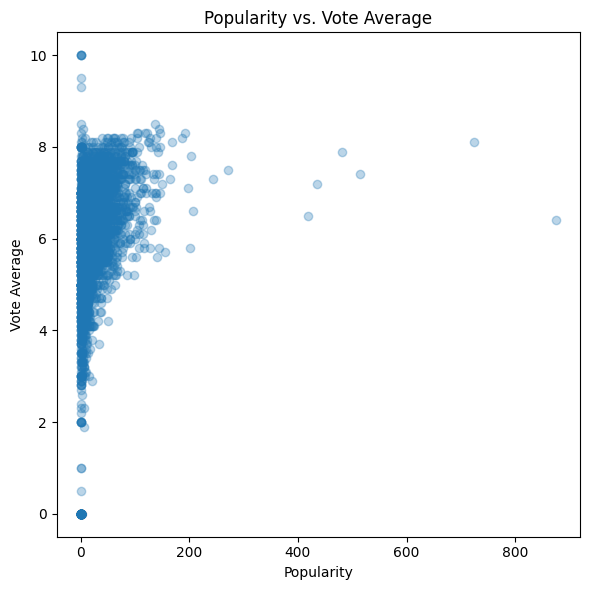

Pearson correlation between popularity and vote_average: 0.27


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df['popularity'], df['vote_average'], alpha=0.3)
plt.title('Popularity vs. Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.tight_layout()
plt.show()
corr = df[['popularity','vote_average']].corr().iloc[0,1]
print(f"Pearson correlation between popularity and vote_average: {corr:.2f}")


In [ ]:
top_genres = genre_counts.index[:5]

top_movies_by_genre = {}
for genre in top_genres:
    mask = df['genres'].str.contains(rf'\b{genre}\b')
    subset = df[mask & (df['vote_count'] >= 50)]
    top3 = subset.sort_values('vote_average', ascending=False).head(3)
    top_movies_by_genre[genre] = top3[['title','vote_average','vote_count']]

# Display results
for genre, tbl in top_movies_by_genre.items():
    print(f"\n=== {genre} ===")
    display(tbl.reset_index(drop=True))



=== Drama ===


,title,vote_average,vote_count
0,the shawshank redemption,8.5,8205
1,the godfather,8.4,5893
2,schindler's list,8.3,4329



=== Comedy ===


,title,vote_average,vote_count
0,forrest gump,8.2,7927
1,the apartment,8.1,483
2,modern times,8.1,856



=== Thriller ===


,title,vote_average,vote_count
0,pulp fiction,8.3,8428
1,the dark knight,8.2,12002
2,psycho,8.2,2320



=== Action ===


,title,vote_average,vote_count
0,the dark knight,8.2,12002
1,the empire strikes back,8.2,5879
2,seven samurai,8.2,878



=== Romance ===


,title,vote_average,vote_count
0,forrest gump,8.2,7927
1,the apartment,8.1,483
2,some like it hot,8.0,808


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tag_matrix = tfidf.fit_transform(df['tags'])
cos_sim = cosine_similarity(tag_matrix, tag_matrix)


In [ ]:
def recommend(title, top_n=10):
    title = title.lower().strip()
    idx = df[df['title']==title].index[0]
    sims = list(enumerate(cos_sim[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return df['title'].iloc[[i for i,_ in sims]].tolist()
print(recommend("inception", 5))


['hesher', 'don jon', 'cypher', '(500) days of summer', 'pitch perfect 2']
